1. Loading and plotting the data. Identifying any unusual observations.
2. If necessary, transforming the data to stabilize the variance (e.g., Box-Cox transformation)
3. If the data is non-stationary, take the first difference until the data is stationary
4. Examining ACF/PACF to determine possible candidate models
5. Choose a model and then use the AICc as a criterion to search for a better model
6. Check the residuals from the chosen model by plotting the ACF of the residuals, and doing a Portmanteau test of the       residuals. If they do not look like white noise, try a modified model
7. Once the residuals look like white noise, calculating forecasts

In [ ]:
import pandas as pd
from pandas import DataFrame
from types import ModuleType
import numpy as np

!pip install boto3
import boto3
import json
import re
import importlib
import sys
import os
import re
import ast

!pip install matplotlib
import matplotlib.pyplot as plt

!pip install statsmodels
!pip install pmdarima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import kpss
from scipy.stats import boxcox
from pmdarima.arima import auto_arima
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro
from sklearn.metrics import mean_squared_error

1. LOADING AND PLOTTING DATA. IDENTIFYING ANY UNUSUAL OBSERVATIONS. TRANSFORMING DATA.



In [ ]:
# Loading AGGREGATED time series data for PATTERN FEED

# S3 bucket details
bucket_name = 'asc-clickstream-emr-output'
prefix = 'trendlines/behavior-platform/agg/data_version=dataset576_V11/behaviorDomain=costco/year=2023/'

# Create an S3 client (No need to provide access key and secret key if credentials are available)
s3_client = boto3.client('s3')

# List objects in the bucket
objects = s3_client.list_objects(Bucket=bucket_name, Prefix=prefix)

agg_dfs = pd.DataFrame()
for obj in objects.get('Contents', []):
    key = obj['Key']
    response = s3_client.get_object(Bucket=bucket_name, Key=key)
    content = response['Body'].read().decode('utf-8')
    json_data = pd.read_json(content, lines=True)  # Assuming each line is a JSON object
    agg_dfs = pd.concat([agg_dfs, json_data], ignore_index=True)

In [ ]:
# Loading CUBED time series data for PATTERN FEED

# S3 bucket details
bucket_name = 'asc-clickstream-emr-output'
prefix = 'trendlines/behavior-platform/cube/data_version=dataset576_V11/behaviorDomain=costco/year=2023/'

# Create an S3 client (No need to provide access key and secret key if credentials are available)
s3_client = boto3.client('s3')

# List objects in the bucket
objects = s3_client.list_objects(Bucket=bucket_name, Prefix=prefix)

cube_dfs = pd.DataFrame()
for obj in objects.get('Contents', []):
    key = obj['Key']
    response = s3_client.get_object(Bucket=bucket_name, Key=key)
    content = response['Body'].read().decode('utf-8')
    json_data = pd.read_json(content, lines=True)  # Assuming each line is a JSON object
    cube_dfs = pd.concat([cube_dfs, json_data], ignore_index=True)

In [ ]:
# Loading AGGREGATED time series data for PATH-TO-PURCHASE 

# S3 bucket details
bucket_name = 'asc-clickstream-emr-output'
prefix = 'trendlines/p2p/agg/data_version=dataset576_V11/behaviorDomain=costco/year=2023/'

# Create an S3 client (No need to provide access key and secret key if credentials are available)
s3_client = boto3.client('s3')

# List objects in the bucket
objects = s3_client.list_objects(Bucket=bucket_name, Prefix=prefix)

agg_dfs = pd.DataFrame()
for obj in objects.get('Contents', []):
    key = obj['Key']
    response = s3_client.get_object(Bucket=bucket_name, Key=key)
    content = response['Body'].read().decode('utf-8')
    json_data = pd.read_json(content, lines=True)  # Assuming each line is a JSON object
    agg_dfs = pd.concat([agg_dfs, json_data], ignore_index=True)

In [ ]:
# Loading CUBED time series data for PATH-TO-PURCHASE

# S3 bucket details
bucket_name = 'asc-clickstream-emr-output'
prefix = 'trendlines/p2p/cube/data_version=dataset576_V11/behaviorDomain=costco/year=2023/'

# Create an S3 client (No need to provide access key and secret key if credentials are available)
s3_client = boto3.client('s3')

# List objects in the bucket
objects = s3_client.list_objects(Bucket=bucket_name, Prefix=prefix)

cube_dfs = pd.DataFrame()
for obj in objects.get('Contents', []):
    key = obj['Key']
    response = s3_client.get_object(Bucket=bucket_name, Key=key)
    content = response['Body'].read().decode('utf-8')
    json_data = pd.read_json(content, lines=True)  # Assuming each line is a JSON object
    cube_dfs = pd.concat([cube_dfs, json_data], ignore_index=True)

In [696]:
agg_dfs = agg_dfs.sort_values(by=["date"]).reset_index(drop=True)
cube_dfs = cube_dfs.sort_values(by=["date"]).reset_index(drop=True)

Metrics for Pattern Feed

Universal grouping and aggregating dataframes for all per-domain and per-domain-per-dataset metrics for aggregated and cubed metrics are created for reusing if needed.

Individual aggregated and cubed metrics:

Aggregated metrics: number_of_events_per_domain, number_of_events_per_behavior, bot_events_per_domain, bot_events_per_domain_per_dataset, duplicated_search_term_events, events_with_pids_per_domain, events_with_PIDs_per_domain_per_dataset

Cubed metrics: bot_panelists_per_domain, bot_panelists_per_domain_per_dataset, 

In [749]:
agg_unique_behaviors = agg_dfs["behavior"].unique()
agg_unique_pattern_ids = agg_dfs["patternId"].unique()
agg_unique_datasets = agg_dfs["dataset"].unique()
cube_unique_behaviors = cube_dfs["behavior"].unique()
cube_unique_datasets = cube_dfs["dataset"].unique()


agg_per_domain = agg_dfs.groupby(["date"]).agg({
    "events": "sum",
    "duplicated_searchterm_events": "sum",
    "events_with_PIDs": "sum",
    "bot_events": "sum",
    "deterministic_PIDs_count": "sum"
}).reset_index()

agg_per_domain_per_dataset = agg_dfs.groupby(["date", "dataset"]).agg({
    "events": "sum",
    "duplicated_searchterm_events": "sum",
    "events_with_PIDs": "sum",
    "bot_events": "sum",
    "deterministic_PIDs_count": "sum"
}).reset_index()

cube_per_domain = cube_dfs.groupby(["date"]).agg({
    "events": "sum",
    "duplicated_searchterm_events": "sum",
    "events_with_PIDs": "sum",
    "bot_events": "sum",
    "deterministic_PIDs_count": "sum",
    "panelists": "sum",
    "bot_panelists": "sum",
    "user_sessions": "sum"
}).reset_index()

cube_per_domain_per_dataset = cube_dfs.groupby(["date", "dataset"]).agg({
    "events": "sum",
    "duplicated_searchterm_events": "sum",
    "events_with_PIDs": "sum",
    "bot_events": "sum",
    "deterministic_PIDs_count": "sum",
    "panelists": "sum",
    "bot_panelists": "sum",
    "user_sessions": "sum"
}).reset_index()



number_of_events_per_domain = agg_dfs.groupby(["date", "behavior"]).agg({
    "events": "sum",
    "duplicated_searchterm_events": "sum",
    "events_with_PIDs": "sum",
    "bot_events": "sum",
    "deterministic_PIDs_count": "sum"
}).reset_index()

for behavior in agg_unique_behaviors:
    number_of_events_per_domain[number_of_events_per_domain["behavior"] == behavior]

# Number of events per domain per behavior ??????
number_of_events_per_behavior = agg_dfs.groupby(["date", "patternId"]).agg({
    "events": "sum",
    "duplicated_searchterm_events": "sum",
    "events_with_PIDs": "sum",
    "bot_events": "sum",
    "deterministic_PIDs_count": "sum"
}).reset_index()

for pattern_id in agg_unique_pattern_ids:
    number_of_events_per_behavior[number_of_events_per_behavior["patternId"] == pattern_id]
    
    
# Count bot panelists per domain
bot_panelists_per_domain = cube_per_domain[["date", "bot_panelists"]]

# Count bot panelists per domain per dataset
bot_panelists_per_domain_per_dataset = cube_per_domain_per_dataset

for dataset in cube_unique_datasets:
    bot_panelists_per_domain_per_dataset[bot_panelists_per_domain_per_dataset["dataset"] == dataset]

# Bot events per domain
bot_events_per_domain = agg_per_domain[["date", "bot_events"]]

# Bot events per domain per dataset
bot_events_per_domain_per_dataset = agg_per_domain_per_dataset

for dataset in agg_unique_datasets:
    bot_events_per_domain_per_dataset[bot_events_per_domain_per_dataset["dataset"] == dataset]

# Duplicated search term events per domain
duplicated_search_term_events = agg_per_domain

# Events with PIDs per domain
events_with_pids_per_domain = agg_per_domain[["date", "events_with_PIDs"]]

# Events with PIDs per domain per dataset
events_with_PIDs_per_domain_per_dataset = agg_per_domain_per_dataset

for dataset in agg_unique_datasets:
    events_with_PIDs_per_domain_per_dataset[events_with_PIDs_per_domain_per_dataset["events_with_PIDs"] == dataset]

Metrics for Path-to-purchase

Universal grouping and aggregating dataframes for all per-domain and per-domain-per-dataset metrics for aggregated and cubed metrics are created for reusing if needed.

Individual aggregated and cubed metrics:

Aggregated metrics:

Cubed metrics:

In [617]:
# Metrics

agg_unique_behaviors = agg_dfs["behavior"].unique()
agg_unique_pattern_ids = agg_dfs["patternId"].unique()
agg_unique_datasets = agg_dfs["dataset"].unique()
cube_unique_behaviors = cube_dfs["behavior"].unique()
cube_unique_datasets = cube_dfs["dataset"].unique()

"""
Universal grouping and aggregating dataframes for all per-domain and 
per-domain-per-dataset metrics for aggregated and cubed metrics
"""
agg_per_domain = agg_dfs.groupby(["date"]).agg({
    "events_by_product": "sum",
    "events_by_product_in_catalog": "sum",
    "bot_events_by_product": "sum",
    "events_by_product_notnull_PID": "sum",
    "events_by_product_notnull_deterministic_PID": "sum"
}).reset_index()

agg_per_domain_per_dataset = agg_dfs.groupby(["date", "dataset"]).agg({
    "events_by_product": "sum",
    "events_by_product_in_catalog": "sum",
    "bot_events_by_product": "sum",
    "events_by_product_notnull_PID": "sum",
    "events_by_product_notnull_deterministic_PID": "sum"
}).reset_index()

cube_per_domain = cube_dfs.groupby(["date"]).agg({
    "events_by_product": "sum",
    "events_by_product_in_catalog": "sum",
    "bot_events_by_product": "sum",
    "events_by_product_notnull_PID": "sum",
    "events_by_product_notnull_deterministic_PID": "sum",
    "panelists": "sum",
    "bot_panelists": "sum",
    "user_sessions": "sum",
    "products": "sum",
    "products_in_catalog": "sum"
}).reset_index()

cube_per_domain_per_dataset = cube_dfs.groupby(["date", "dataset"]).agg({
    "events_by_product": "sum",
    "events_by_product_in_catalog": "sum",
    "bot_events_by_product": "sum",
    "events_by_product_notnull_PID": "sum",
    "events_by_product_notnull_deterministic_PID": "sum",
    "panelists": "sum",
    "bot_panelists": "sum",
    "user_sessions": "sum",
    "products": "sum",
    "products_in_catalog": "sum"
}).reset_index()


# Number of events per domain
number_of_events_per_domain = cube_per_domain[["date", "events_by_product"]]


# Number of events per domain per behavior
number_of_events = cube_dfs.groupby(["date", "behavior"]).agg({
    "events_by_product": "sum",
}).reset_index()

for behavior in cube_unique_behaviors:
    number_of_events[number_of_events["behavior"] == behavior]

# Count bot panelists per domain
bot_panelists_per_domain = cube_per_domain[["date", "bot_panelists"]]

# Count bot panelists per domain per dataset
bot_panelists_per_domain_per_dataset = cube_per_domain_per_dataset

for dataset in cube_unique_datasets:
    bot_panelists_per_domain_per_dataset[bot_panelists_per_domain_per_dataset["dataset"] == dataset]

# Bot events per domain
bot_events_per_domain = cube_per_domain[["date", "bot_events_by_product"]]

# Bot events per domain per dataset
bot_events_per_domain_per_dataset = cube_per_domain_per_dataset[["date", "dataset", "bot_events_by_product"]]

for dataset in cube_unique_datasets:
    bot_events_per_domain_per_dataset[bot_events_per_domain_per_dataset["dataset"] == dataset]

# Events by product notnull PID
events_by_product_notnull_pid = cube_per_domain[["date", "events_by_product_notnull_PID"]]

# Events by product notnull deterministic PID
events_by_product_notnull_deterministic_pid = cube_per_domain[["date", "events_by_product_notnull_deterministic_PID"]]

# Products in catalog
products_in_catalog = cube_per_domain[["date", "products_in_catalog"]]

# Events by product in catalog
events_by_product_in_catalog = cube_per_domain[["date", "events_by_product_in_catalog"]]

In [781]:
data = events_with_pids_per_domain
#data = data[["date", "duplicated_searchterm_events"]]
data.set_index("date", inplace=True)

In [ ]:
data

Box-Cox Transformation



In [783]:
# Copied from https://www.geo.fu-berlin.de/en/v/soga-py/Advanced-statistics/time-series-analysis/ARIMA-modelling-in-Python/index.html
boxcox_transformed_data, boxcox_lambda = boxcox(data.events_with_PIDs + 10)
boxcox_transformed_data = pd.Series(
    boxcox_transformed_data, index=data.index
)

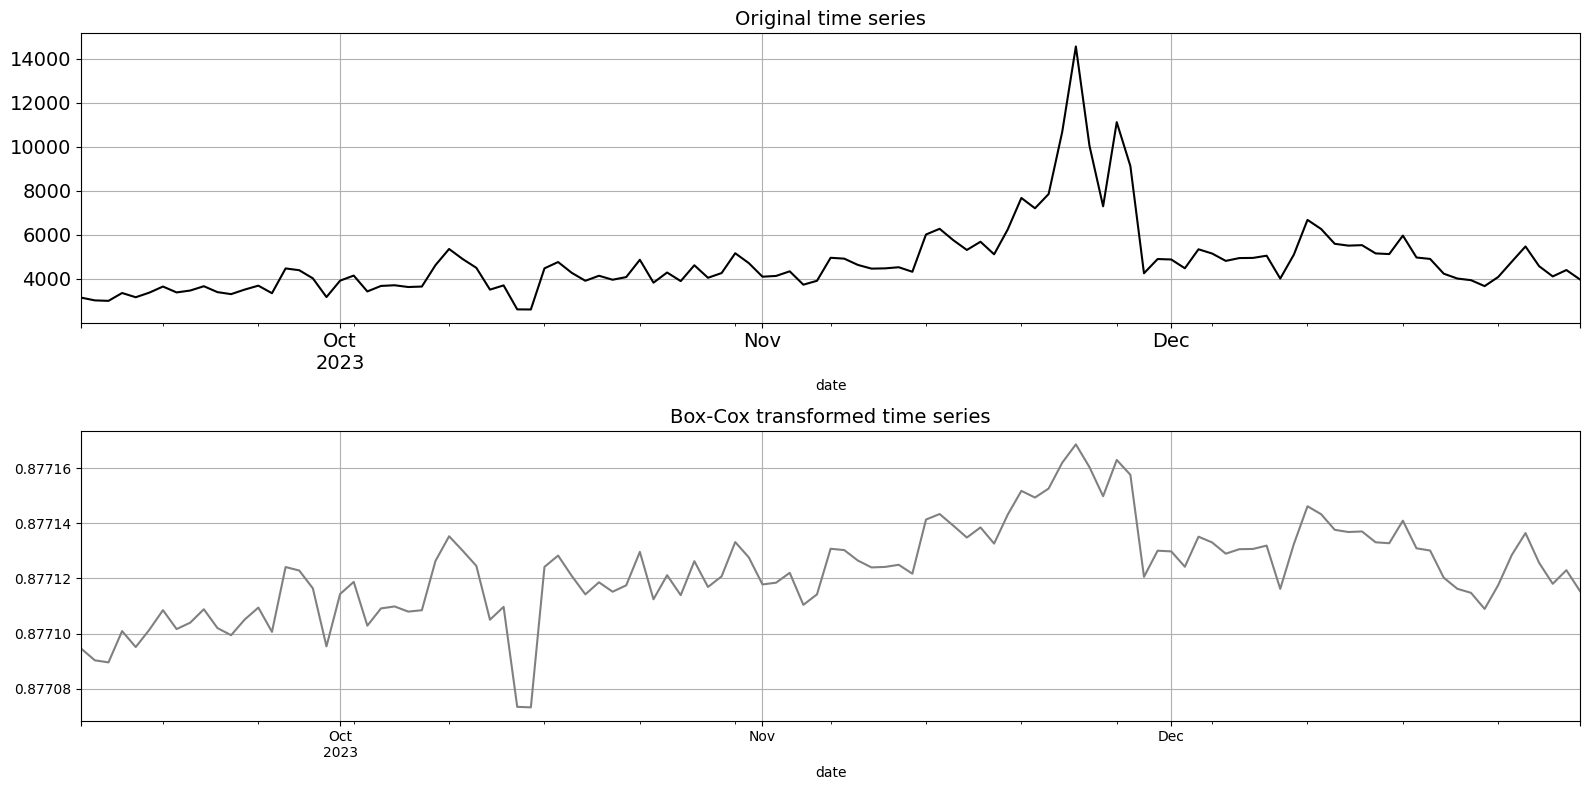

In [784]:
# Copied from https://www.geo.fu-berlin.de/en/v/soga-py/Advanced-statistics/time-series-analysis/ARIMA-modelling-in-Python/index.html
fig, ax = plt.subplots(2, 1, figsize=(16, 8))
data.events_with_PIDs.plot(ax=ax[0], color="black", fontsize=14)
ax[0].set_title("Original time series", fontsize=14)


boxcox_transformed_data.plot(
    ax=ax[1],
    color="grey",
)
ax[1].set_title("Box-Cox transformed time series", fontsize=14)

ax[0].grid()
ax[1].grid()

plt.tight_layout()
plt.show()

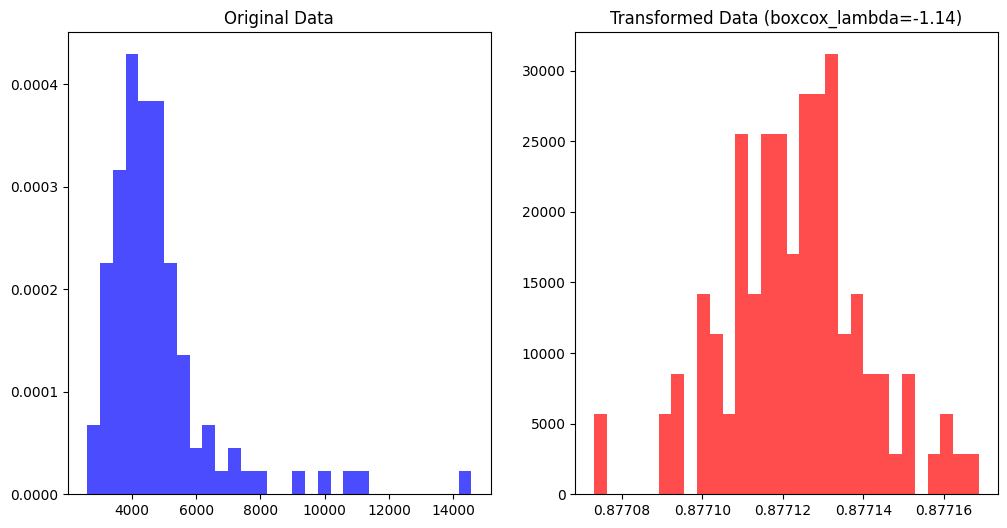

In [785]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(data, bins=30, density=True, color='blue', alpha=0.7)
plt.title('Original Data')
plt.subplot(1, 2, 2)
plt.hist(boxcox_transformed_data, bins=30, density=True, color='red', alpha=0.7)
plt.title('Transformed Data (boxcox_lambda={:.2f})'.format(boxcox_lambda))
plt.show()

Shapiro-Wilk test

In [786]:
statistic, p_value = shapiro(data)

print("Shapiro-Wilk Test Statistic:", statistic)
print("p-value:", p_value)

alpha = 0.05  # significance level
if p_value > alpha:
    print("Sample looks Gaussian")
else:
    print("Sample does not look Gaussian")

Shapiro-Wilk Test Statistic: 0.7377690289770416
p-value: 8.598577953281308e-13
Sample does not look Gaussian


In [787]:
print(data.iloc[0])
print(data.iloc[-1])

events_with_PIDs    3150
Name: 2023-09-12 00:00:00, dtype: int64
events_with_PIDs    3976
Name: 2023-12-31 00:00:00, dtype: int64


In [788]:
training_set = boxcox_transformed_data[:"2023-11-30"]
testing_set = boxcox_transformed_data["2023-11-30":]

In [ ]:
training_set

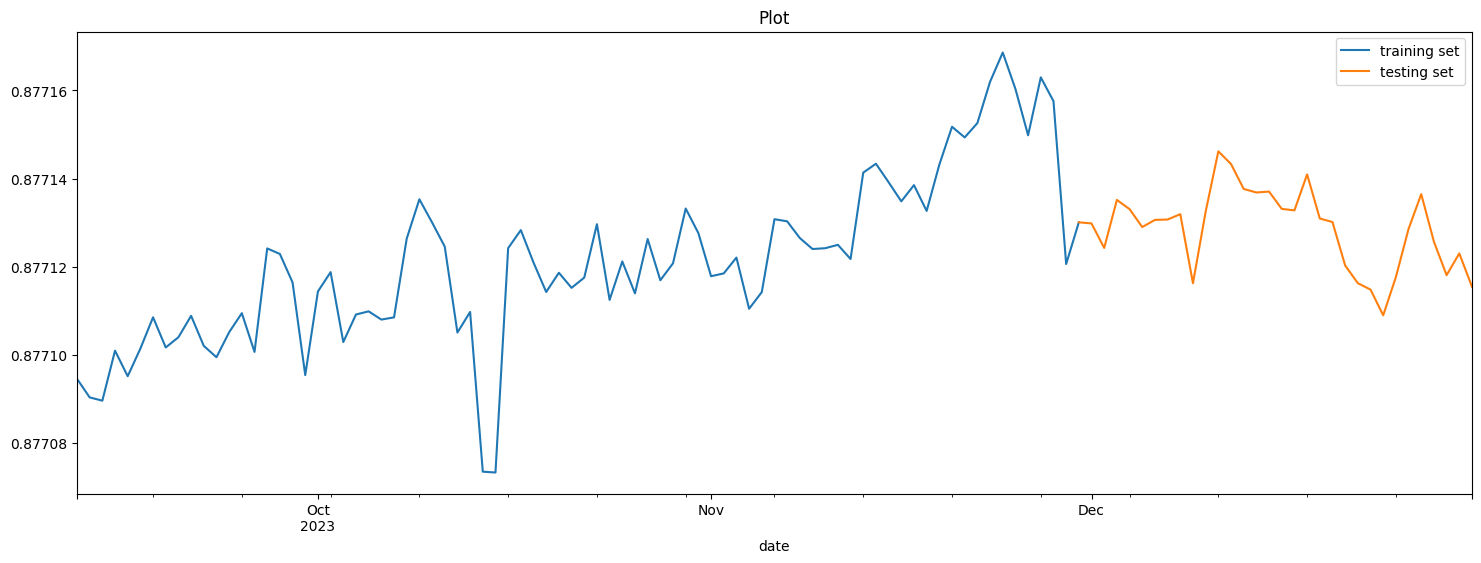

In [790]:
plt.figure(figsize=(18, 6))
plt.title("Plot")
training_set.plot(label="training set")
testing_set.plot(label="testing set")

plt.legend()
plt.show()

3. IF DATA IS NON-STATIONARY, TAKE THE FIRST DIFFERENCE UNTIL IT'S STATIONARY

   Augmented Dickey-Fuller statistical test for deciding whether the data is stationary or non-stationary. If p-value > 0.05,      data is non-stationary and the first differentiation has to be applied. If p-value <= 0.05, data is stationary and can be      modeled as it is.
   
   Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test trend-stationarity

In [791]:
# Augmented Dickey-Fuller statictical test of stationarity/non-stationarity

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")
        
check_stationarity(training_set)

ADF Statistic: -0.800353
p-value: 0.819018
Critical Values:
	1%: -3.523
	5%: -2.902
	10%: -2.588
Non-stationary


In [792]:
# Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test of trend stationarity/non-stationarity

  # Copied from https://www.geo.fu-berlin.de/en/v/soga-py/Advanced-statistics/time-series-analysis/ARIMA-modelling-in-Python/index.html

def kpss_test(series, **kw):
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f"KPSS Statistic: {statistic}")
    print(f"p-value: {p_value}")
    print(f"num lags: {n_lags}")
    print("Critial Values:")
    for key, value in critical_values.items():
        print(f"   {key} : {value}")
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')
    
kpss_test(training_set)

KPSS Statistic: 1.1303898126990763
p-value: 0.01
num lags: 5
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


/tmp/ipykernel_85/2475755740.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kw)


In [794]:
# Execute only if data is non-stationary
differenced_data = training_set.diff()
differenced_data = training_set.dropna()

In [798]:
# Execute only in case of need 2nd, 3rd,...,n-th differentiation of the data 
differenced_data = differenced_data.diff()
differenced_data = differenced_data.dropna()

In [799]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")
        
check_stationarity(differenced_data)

ADF Statistic: -6.518414
p-value: 0.000000
Critical Values:
	1%: -3.523
	5%: -2.902
	10%: -2.588
Stationary


In [800]:
# Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test of trend stationarity/non-stationarity

  # Copied from https://www.geo.fu-berlin.de/en/v/soga-py/Advanced-statistics/time-series-analysis/ARIMA-modelling-in-Python/index.html

def kpss_test(series, **kw):
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f"KPSS Statistic: {statistic}")
    print(f"p-value: {p_value}")
    print(f"num lags: {n_lags}")
    print("Critial Values:")
    for key, value in critical_values.items():
        print(f"   {key} : {value}")
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')
    
kpss_test(differenced_data)

KPSS Statistic: 0.16748799761702676
p-value: 0.1
num lags: 23
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


/tmp/ipykernel_85/2343794073.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kw)


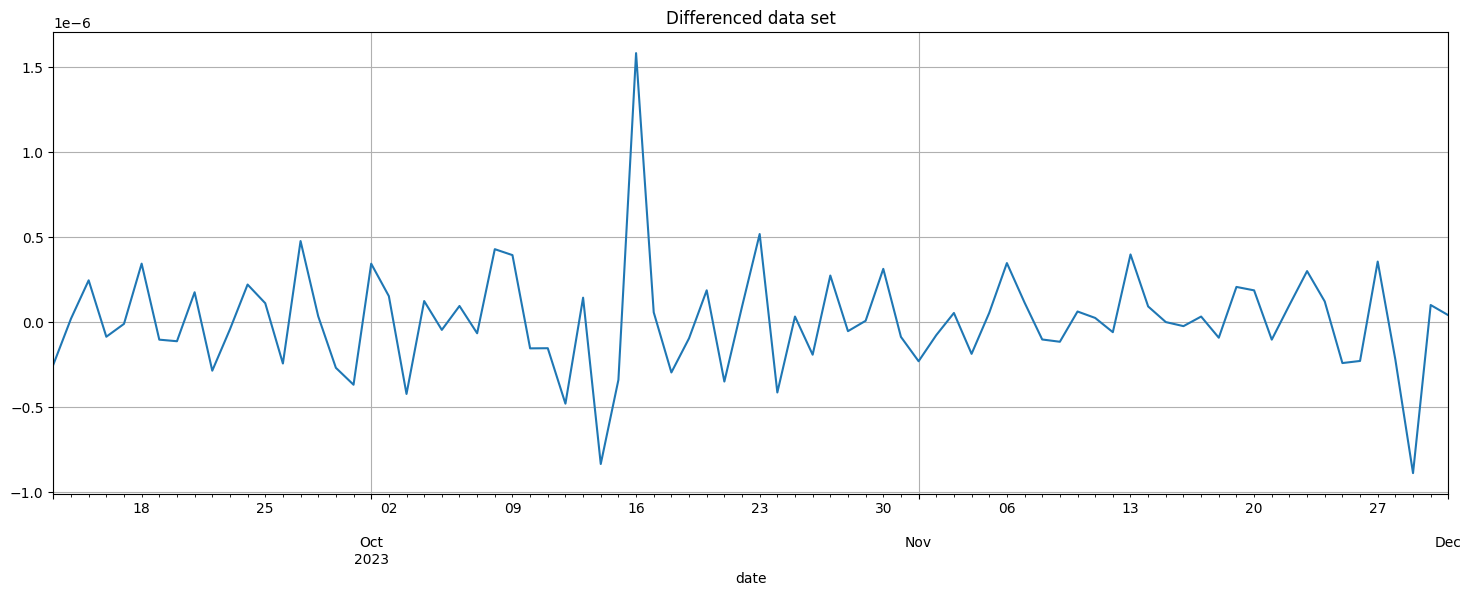

In [130]:
plt.figure(figsize=(18, 6))
plt.title("Differenced data set")
differenced_data.plot()

plt.grid()
plt.show()

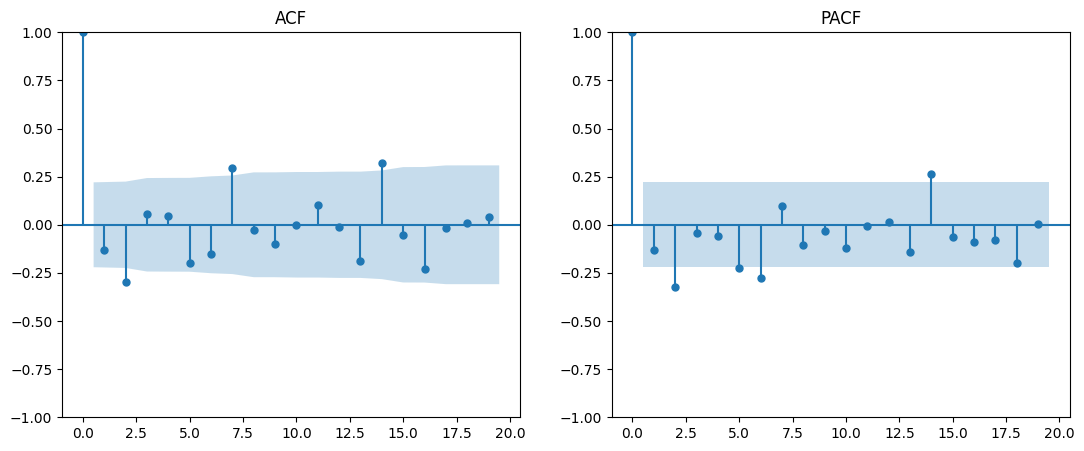

In [801]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

plot_acf(
    #boxcox_transformed_data,
    differenced_data, 
    ax=ax[0])
ax[0].set_title("ACF")


plot_pacf(
    #boxcox_transformed_data,
    differenced_data, 
    method="ywm", 
    ax=ax[1]
)  ## add the calculation method running in the background ("ywm")

ax[1].set_title("PACF")
plt.show()

5. CHOOSING MODEL AND OPTIMIZING IT USING AICc


In [ ]:
# Series for auto ARIMA
initial_date = training_set.index[0]
series = pd.Series(
    training_set, index=pd.date_range(initial_date, periods=len(training_set), freq="D"), name="Series"
)
series.describe()

In [ ]:
# Series for manualy found and optimized ARIMA model
initial_date_diff = differenced_data.index[0]
series_diff = pd.Series(
    differenced_data, index=pd.date_range(initial_date_diff, periods=len(differenced_data), freq="D"), name="Series"
)
series_diff.describe()

In [804]:
# fit model
model = ARIMA(series_diff, order=(2, 2, 3))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 Series   No. Observations:                   79
Model:                 ARIMA(2, 2, 3)   Log Likelihood                 722.104
Date:                Sat, 02 Mar 2024   AIC                          -1432.209
Time:                        23:05:09   BIC                          -1418.146
Sample:                    09-13-2023   HQIC                         -1426.584
                         - 11-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7472   3.16e-20  -2.36e+19      0.000      -0.747      -0.747
ar.L2         -0.5340   3.01e-19  -1.77e+18      0.000      -0.534      -0.534
ma.L1               0   3.22e-20          0      1.0

/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
print(
    "AR 1 =",
    round(model_fit.params["ar.L1"], 4),
    "AR 2 =",
    round(model_fit.params["ar.L2"], 4),
    "AR 3 =",
    round(model_fit.params["ar.L3"], 4),
    "sigma =",
    round(model_fit.params["sigma2"], 4),
)

model_fit.aicc

In [ ]:
model = ARIMA(series, order=(2,2,3))
model_fit = model.fit()
print(f"ARIM(2,2,3) - AICc: {round(model_fit.aicc,2)}")

model = ARIMA(series, order=(2,2,4))
model_fit = model.fit()
print(f"ARIMA(2,2,4) - AICc: {round(model_fit.aicc,2)}")

model = ARIMA(series, order=(5,2,3))
model_fit = model.fit()
print(f"ARIMA(5,2,3) - AICc: {round(model_fit.aicc,2)}")

model = ARIMA(series, order=(5,2,4))
model_fit = model.fit()
print(f"ARIMA(5,2,4) - AICc: {round(model_fit.aicc,2)}")

model = ARIMA(series, order=(6,2,3))
model_fit = model.fit()
print(f"ARIMA(6,2,3) - AICc: {round(model_fit.aicc,2)}")

model = ARIMA(series, order=(6,2,4))
model_fit = model.fit()
print(f"ARIMA(6,2,4) - AICc: {round(model_fit.aicc,2)}")

Auto ARIMA model (Hyndman and Khandakar algorithm)

In [806]:
auto_model = auto_arima(series)
forecast, conf_int = auto_model.predict(n_periods=len(testing_set), return_conf_int=True, alpha=0.05)
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   80
Model:               SARIMAX(0, 1, 2)   Log Likelihood                 780.481
Date:                Sat, 02 Mar 2024   AIC                          -1552.961
Time:                        23:07:25   BIC                          -1543.483
Sample:                    09-12-2023   HQIC                         -1549.164
                         - 11-30-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    3.38e-07   5.53e-07      0.611      0.541   -7.46e-07    1.42e-06
ma.L1         -0.2043   2.72e-13  -7.52e+11      0.000      -0.204      -0.204
ma.L2         -0.3915   8.48e-13  -4.62e+11      0.000      -0.392      -0.392
sigma2      1.316e-10    2.4e-10      0.549      0.583   -3.38e-10    6.01e-10
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):                62.36
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                            -0.96
Prob(H) (two-sided):                  0.61   Kurtosis:                         6.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.15e+28. Standard errors may be unstable.
"""

In [809]:
seasonal_order = auto_model.seasonal_order
print("Seasonal Order:", seasonal_order)

Seasonal Order: (0, 0, 0, 0)


In [810]:
forecast_df = pd.DataFrame({
    'Forecast': forecast,
    'Lower_CI': conf_int[:, 0],  # Lower bound of the confidence interval
    'Upper_CI': conf_int[:, 1]   # Upper bound of the confidence interval
}, index=forecast.index)

6. CHECKING RESIDUALS by plotting the ACF of the residuals and doing a Portmanteau residuals test

   If residuals don't look like white noise, different model should be tried



In [428]:
residuals = pd.DataFrame(auto_model.resid())
residuals_diff = model_fit.resid

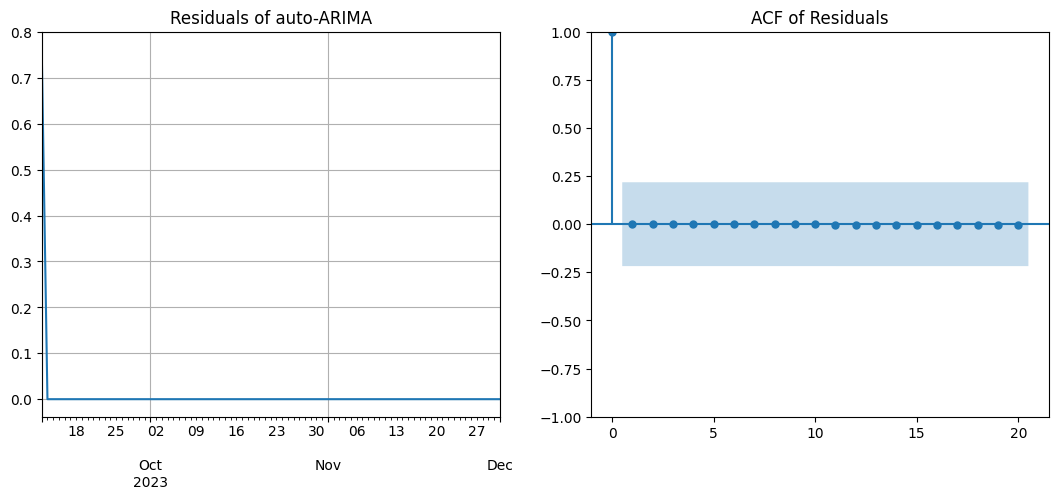

In [429]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

residuals.plot(ax=ax[0], legend=False)
ax[0].grid()
ax[0].set_title("Residuals of auto-ARIMA")


plot_acf(residuals, ax=ax[1])

ax[1].set_title("ACF of Residuals")
plt.show()


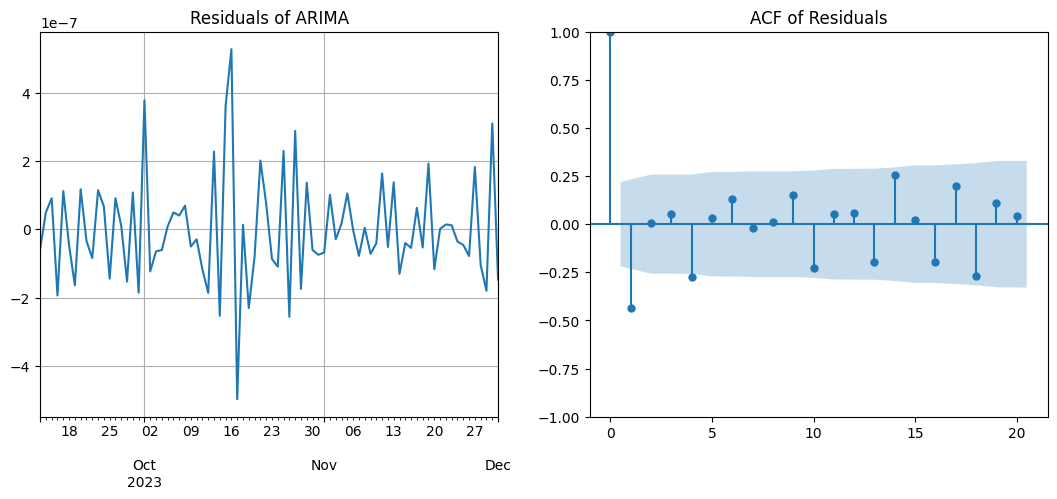

In [430]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

residuals_diff.plot(ax=ax[0], legend=False)
ax[0].grid()
ax[0].set_title("Residuals of ARIMA")


plot_acf(residuals_diff, ax=ax[1])

ax[1].set_title("ACF of Residuals")
plt.show()

In [561]:
# Ljung-Box test

# Copied from https://www.geo.fu-berlin.de/en/v/soga-py/Advanced-statistics/time-series-analysis/ARIMA-modelling-in-Python/index.html

# perform Ljung-Box test on residuals with lag=10
Btest = acorr_ljungbox(
    auto_model.resid(), lags=[10], return_df=True, model_df=5
)  ## ARIMA model_df = lags - df , df =  p +q

Btest

if Btest.iloc[0]["lb_pvalue"] > 0.05:
    print("White noise")
else:
    print("Error")

White noise


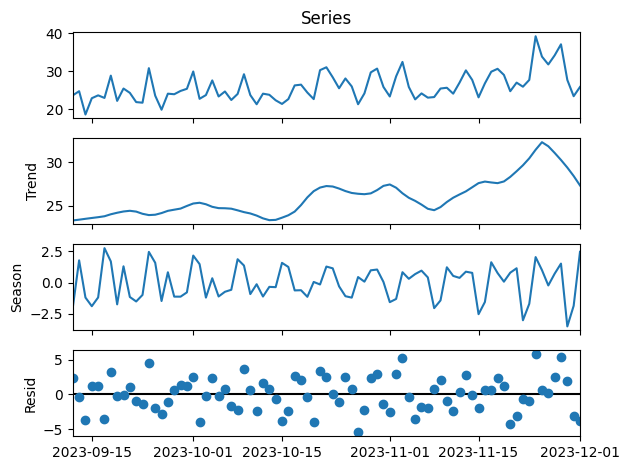

In [39]:
"""
This window size determines how many neighboring data points are considered when calculating the seasonal
component at each point in the time series.
A larger seasonal value results in smoother seasonal patterns, while a smaller value captures more detailed
variations in the seasonality.
"""
stl = STL(series, seasonal=31)
res = stl.fit()
fig = res.plot()

7. CALCULATING FORECASTS


In [ ]:
plt.figure(figsize=(18, 6))
series_diff.plot(color="grey", label="training set")
#testing_set.plot(color="red", label="testing set")
plt.plot(model_fit.fittedvalues, color="blue", label="fitted values")

plt.legend()
plt.show()

In [ ]:
# Get fitted values
fitted_values = auto_model.predict_in_sample()
#fitted_values = fitted_values.iloc[1:]
#training_set2 = training_set.iloc[1:]

# Plot historic data and fitted values
plt.figure(figsize=(10, 6))
#plt.plot(training_set.index, training_set.values, label='Actual')
series.plot()
plt.plot(training_set.index, fitted_values, label='Fitted', linestyle='--')
plt.title('Historic Data and Fitted Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
model = ARIMA(series, order=(0, 2, 0))
fitted = model.fit()

forecast_series = fitted.forecast(len(training_set), alpha=0.05)

forecast = fitted.get_forecast(len(training_set))
conf_int_95 = forecast.conf_int(alpha=0.05)  # 95% conf
conf_int_80 = forecast.conf_int(alpha=0.2)  # 80% conf


plt.figure(figsize=(13, 4))
plt.title("")
plt.plot(training_set, color="black", label="training set")
plt.plot(testing_set, color="red", label="testing set")
plt.plot(forecast_series, label="forecast", color="blue")


plt.fill_between(
    conf_int_95.index,
    conf_int_95["lower Series"],
    conf_int_95["upper Series"],
    color="b",
    alpha=0.1,
)

plt.fill_between(
    conf_int_80.index,
    conf_int_80["lower Series"],
    conf_int_80["upper Series"],
    color="b",
    alpha=0.2,
)


plt.legend()
plt.show()

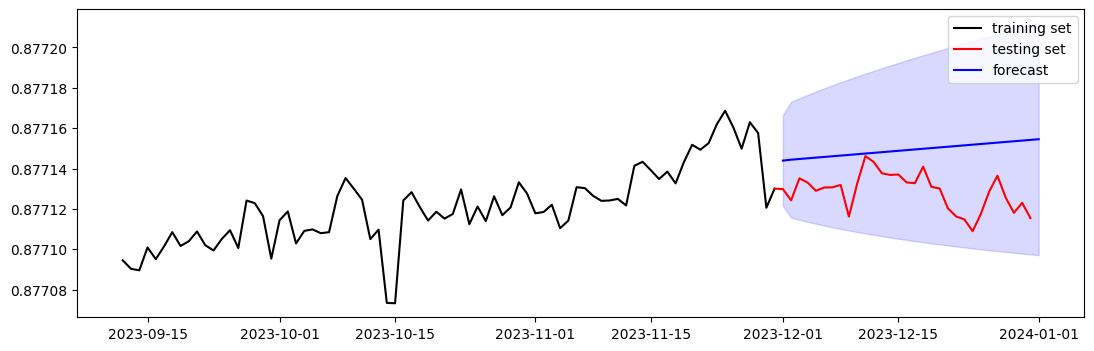

In [811]:
plt.figure(figsize=(13, 4))
plt.title("")
plt.plot(training_set, color="black", label="training set")
plt.plot(testing_set, color="red", label="testing set")
plt.plot(forecast_df.Forecast, label="forecast", color="blue")

plt.fill_between(
    forecast_df.index,
    forecast_df["Lower_CI"],
    forecast_df["Upper_CI"],
    color="b",
    alpha=0.15,
)

"""
plt.fill_between(
    conf_int_95.index,
    conf_int_95["lower Series"],
    conf_int_95["upper Series"],
    color="b",
    alpha=0.1,
)


plt.fill_between(
    conf_int_80.index,
    conf_int_80["lower Series"],
    conf_int_80["upper Series"],
    color="b",
    alpha=0.2,
)
"""

plt.legend()
plt.show()

In [224]:
lower_series = forecast_df.loc["2023-12-07"]["Lower_CI"]
upper_series = forecast_df.loc["2023-12-07"]["Upper_CI"]
value = forecast_df.loc["2023-12-07"]["Forecast"]

print(upper_series)
print(value)
print(lower_series)

if lower_series < value < upper_series:
    print("Value within expected boundaries")
else:
    print("Anomaly")

1.4478167954303238
1.4301576680772097
1.4124985407240955
Value within expected boundaries


In [ ]:
for i in range(0, len(forecast_df)):
    print(forecast_df.iloc[i])

ARIMA MODEL EVALUATION


In [ ]:
import statsmodels.api as sm
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
 # prepare training dataset
 train_size = int(len(X) * 0.66)
 train, test = X[0:train_size], X[train_size:]
 history = [x for x in train]
 # make predictions
 predictions = list()
 for t in range(len(test)):
   model = ARIMA(history, order=arima_order)
   #model = sm.tsa.SARIMAX(history, order=arima_order, seasonal_order=seasonal_order)
   model_fit = model.fit()
   yhat = model_fit.forecast()[0]
   predictions.append(yhat)
   history.append(test[t])
   # calculate out of sample error
 error = mean_squared_error(test, predictions)
 return error

evaluate_arima_model(series, (0,1,2))